# Lens modeling of DESIJ1018-0121 with `lenstronomy`
**Authors:** MD. Jobair Hasan, Anowar Shajib

In [ ]:
import h5py
import joblib
import lenstronomy.Util.mask_util as mk
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Workflow.fitting_sequence import FittingSequence

drive.mount("/content/drive")

## Import the required packages

In [1]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    pass
except ModuleNotFoundError:
    !pip install lenstronomy

In [2]:
# import the necessary python libraries


%matplotlib inline

## Read the data file


In [3]:
with h5py.File("DESIJ1018-0121_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.018610074701766573,
 'dec_at_xy_0': -5.799999999999994,
 'exposure_time': array([[486.32956, 387.50772, 555.4221 , ..., 561.57306, 436.89725,
         453.8047 ],
        [525.3609 , 455.32626, 433.4547 , ..., 467.7759 , 393.7413 ,
         575.8005 ],
        [406.4474 , 553.6718 , 442.7201 , ..., 439.1787 , 455.65027,
         465.92584],
        ...,
        [424.9911 , 470.85703, 480.29526, ..., 431.6869 , 500.74237,
         476.34906],
        [416.17792, 491.75076, 384.38663, ..., 364.7395 , 248.40552,
         394.68134],
        [461.31955, 487.39075, 457.4765 , ..., 516.8107 , 438.08667,
         375.04907]], dtype=float32),
 'image_data': array([[ 0.01961958, -0.00048153, -0.01787547, ..., -0.01659699,
         -0.00921571,  0.01057982],
        [ 0.02892776,  0.01651465, -0.00482212, ..., -0.00829422,
         -0.00578246,  0.0005834 ],
        [ 0.01247546,  0.00889849,  0.00884483, ...,  0.01536562,
          0.0021972 , -0.01391137],
        ...,
   

## Load the PSF data

In [4]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"

kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

## Get the image data from `kwargs_data` and plot it

C:\Users\Zobai\AppData\Local\Temp\ipykernel_6524\2608440245.py:4: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')
C:\Users\Zobai\AppData\Local\Temp\ipykernel_6524\2608440245.py:5: RuntimeWarning: invalid value encountered in log10
  ax2.matshow(np.log10(image_data), origin='lower', cmap='cubehelix')


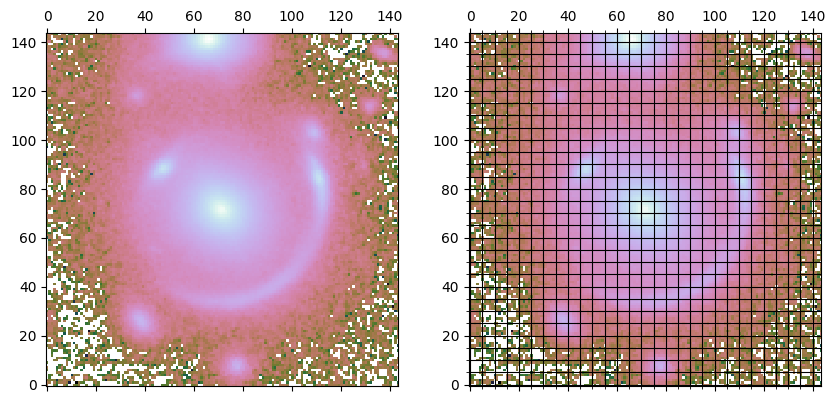

In [5]:
image_data = kwargs_data["image_data"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
ax2.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
plt.show()

## Make Likelihood mask and plot it

C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Zobai\AppData\Local\Temp\ipykernel_6524\1221819075.py:30: RuntimeWarning: invalid value encountered in log10
  image = np.log10(image_data)


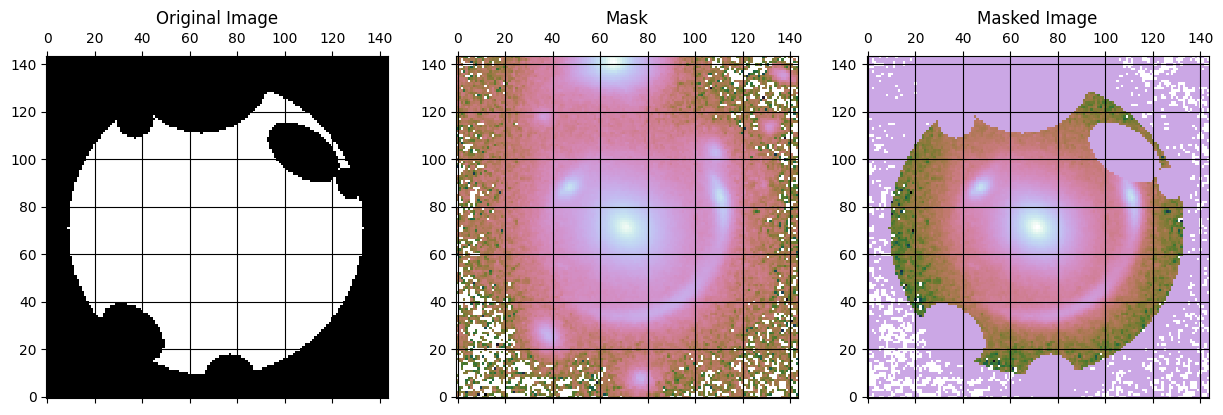

In [6]:
x_c, y_c = np.meshgrid(np.arange(144), np.arange(144))
mask = 1 - mk.mask_center_2d(71, 71, 62, x_c, y_c)

mask_params = [
    [65, 140, 30, 29, 0],
    # [55, 45, 2, 2, 0],
    [108, 103, 17, 10, np.pi * 145 / 180],
    [77, 7, 11, 11, 0],
    [36, 27, 15, 10, np.pi * 140 / 180],
    [37, 117, 8, 8, 0],
    [127, 90, 7, 5, np.pi * 115 / 180],
    # [47, 88, 10, 5, np.pi*45/180]
]

for mask_param in mask_params:
    mask *= 1 - mk.mask_ellipse(
        x_c,
        y_c,
        mask_param[0],
        mask_param[1],
        mask_param[2],
        mask_param[3],
        mask_param[4],
    )

mask[mask >= 1] = 1
mask[mask < 0] = 0

image = np.log10(image_data)
masked_image = np.multiply(image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(mask, origin="lower", cmap="gray")
ax1.grid(which="both", color="black")
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(image, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax3.matshow(masked_image, origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")

## Fit Initial Lensing Model Fitting with the Created Mask using `Lenstronomy`

In [7]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE"]

In [8]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = [
    {
        "theta_E": 2.8791944210872153,
        "gamma": 1.9123338961332277,
        "e1": 0.02141023947880997,
        "e2": 0.10338236031338606,
        "center_x": 0.10318024299174353,
        "center_y": -0.07641337271624558,
    },
    {
        "gamma1": 0.017403457194550807,
        "gamma2": -0.014496327790101028,
        "ra_0": 0.0,
        "dec_0": 0.0,
    },
]
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

fixed_lens.append({"ra_0": 0.0, "dec_0": 0.0})

kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})

kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1.0,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})

kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = [
    {
        "amp": 1,
        "R_sersic": 1.2494023489847377,
        "n_sersic": 4.0,
        "e1": 0.02141023947880997,
        "e2": 0.10338236031338606,
        "center_x": 0.10318024299174353,
        "center_y": -0.07641337271624558,
    }
]
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# source galaxy's light model
fixed_source = []
kwargs_source_init = [
    {
        "amp": 1,
        "R_sersic": 0.2198547073280723,
        "n_sersic": 1.0,
        "e1": 0.03285873811300954,
        "e2": -0.08944386224976253,
        "center_x": -0.25720822220379513,
        "center_y": -0.21476472100327648,
    },
    {
        "amp": 1,
        "n_max": 10,
        "beta": 0.030838456648300525,
        "center_x": -0.25720822220379513,
        "center_y": -0.21476472100327648,
    },
]
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})

fixed_source.append({"n_max": 10})

kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_source_sigma.append({"beta": 0.1, "center_x": 0.1, "center_y": 0.1})

kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_lower_source.append({"beta": 0.01, "center_x": -10, "center_y": -10})

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.4,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
kwargs_upper_source.append({"beta": 5, "center_x": 10, "center_y": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_source_with_source,
}

In [9]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [10]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has independent
    # solutions of the surface brightness,
    # 'joint-linear': there is one joint solution of the linear
    # coefficients demanded across the bands.
}

In [11]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)

fit_output = chain_list
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

output_path = "./DESIJ1018-0121_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.2016695094464054 reduced X^2 of best position
-5926.634020589671 log likelihood
9864 effective number of data points
[{'theta_E': 2.8781425409600296, 'gamma': 1.9319861694639948, 'e1': 0.021413200869350456, 'e2': 0.10359244109689184, 'center_x': 0.10314548733617177, 'center_y': -0.07645658795264434}, {'gamma1': 0.0172948087312718, 'gamma2': -0.016985761564986095, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.2243951545913847, 'n_sersic': 1.0, 'e1': 0.031446570666397305, 'e2': -0.08645965853676447, 'center_x': -0.26484686266794166, 'center_y': -0.21785501426367085}, {'amp': 1, 'n_max': 10, 'beta': 0.03157782151741702, 'center_x': -0.26484686266794166, 'center_y': -0.21785501426367085}] source result
[{'amp': 1, 'R_sersic': 1.249301353224054, 'n_sersic': 4.0, 'e1': 0.021413200869350456, 'e2': 0.10359244109689184, 'center_x': 0.10314548733617

-1.1916424957686134 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1916424957685445


C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
C:\Users\Zobai\AppData\Local\Temp\ipykernel_6524\1409410907.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


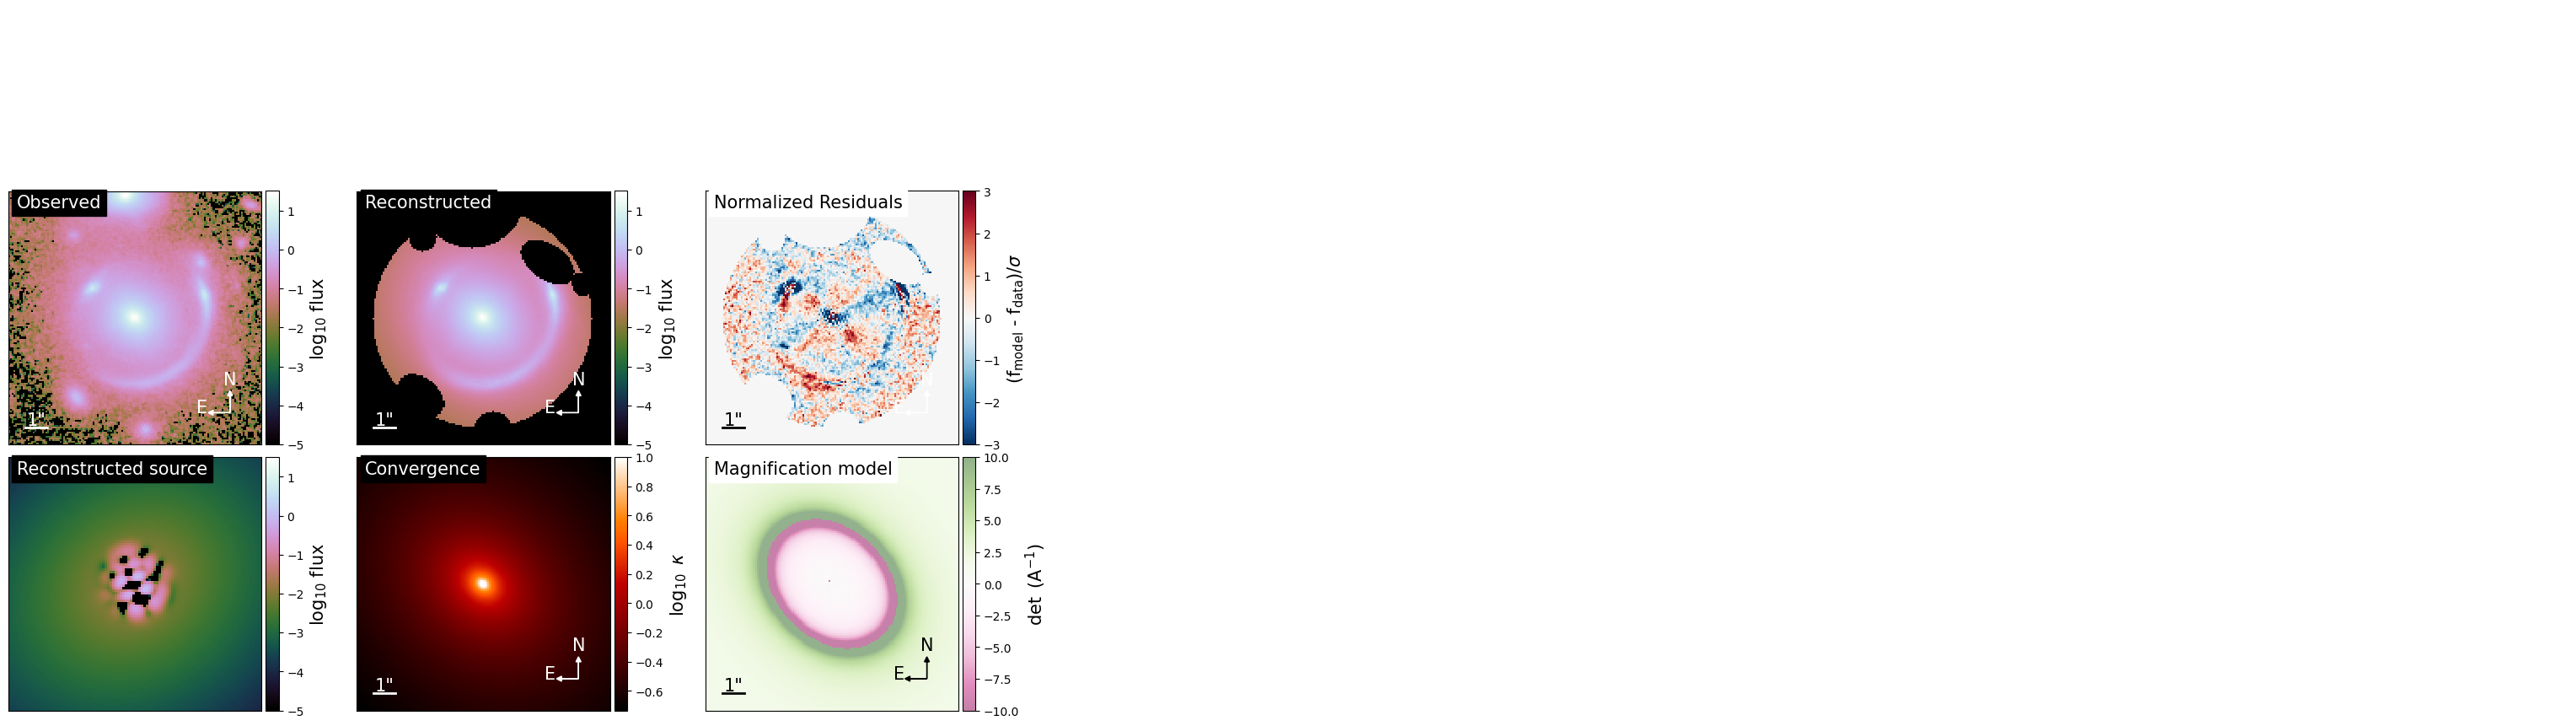

C:\Users\Zobai\AppData\Local\Programs\Python\Python311\Lib\site-packages\lenstronomy\Plots\model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


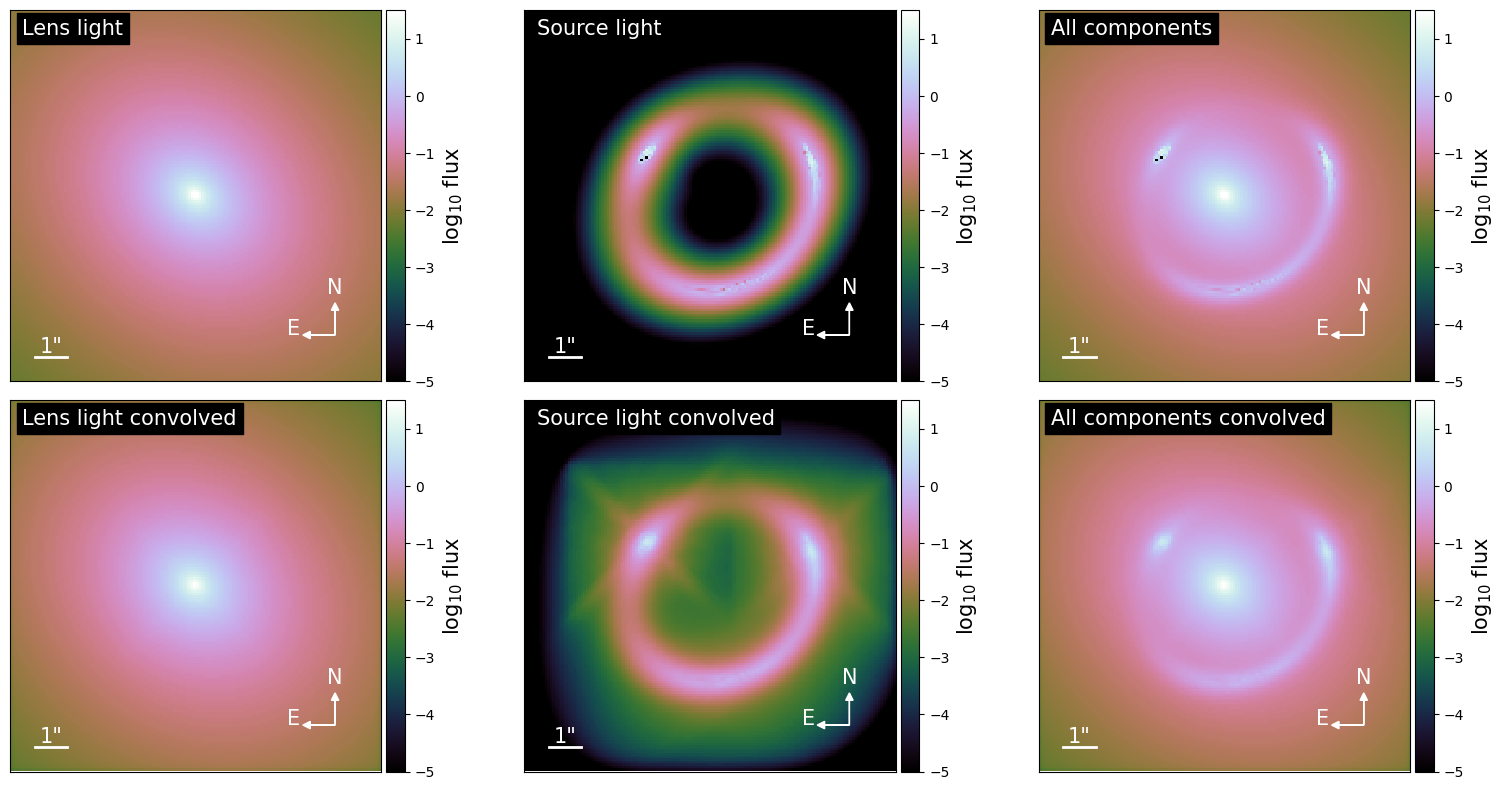

{'kwargs_lens': [{'theta_E': 2.8781425409600296, 'gamma': 1.9319861694639948, 'e1': 0.021413200869350456, 'e2': 0.10359244109689184, 'center_x': 0.10314548733617177, 'center_y': -0.07645658795264434}, {'gamma1': 0.0172948087312718, 'gamma2': -0.016985761564986095, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.2243951545913847, 'n_sersic': 1.0, 'e1': 0.031446570666397305, 'e2': -0.08645965853676447, 'center_x': -0.26484686266794166, 'center_y': -0.21785501426367085}, {'amp': 1, 'n_max': 10, 'beta': 0.03157782151741702, 'center_x': -0.26484686266794166, 'center_y': -0.21785501426367085}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.249301353224054, 'n_sersic': 4.0, 'e1': 0.021413200869350456, 'e2': 0.10359244109689184, 'center_x': 0.10314548733617177, 'center_y': -0.07645658795264434}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [12]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)